# K-D tree fundamentals

TODO: what is a K-D tree

The [nanoflann](https://github.com/jlblancoc/nanoflann) library is used within teqpflsh due to its computational efficiency.

In [1]:
import numpy as np
import teqpflsh
import matplotlib.pyplot as plt

def boxpoly(*, top, bottom, left, right, ptr):
    X = np.array([left, right, right, left, left])
    Y = np.array([bottom, bottom, top, top, bottom])
    return ptr.makeclosedpolygon(X, Y)

In [2]:
ptr = teqpflsh.GeometryFactoryHolder()

# Polygon for the shifted circle
t = np.linspace(0, 2*np.pi, 10000)
X = 0.5 + 0.3*np.cos(t)
Y = 0.3*np.sin(t)
poly1 = ptr.makeclosedpolygon(X, Y)
poly2 = boxpoly(left=0, right=1, bottom=0, top=1, ptr=ptr)

# Polygon for the square [0,1]x[0,1] minus small circle
poly = poly2.difference(poly1)
X, Y = poly.getXY()

def do_one(*, NKD, Nsample, plot=False, close=True):
    def get_random(NKD):
        """ Random points for the tree """
        XX, YY = [], []
        while len(XX) < NKD:
            x_, y_ = np.random.random(2)
            pt = ptr.createPoint(float(x_), float(y_))
            if poly.containsPoint(pt):
                XX.append(x_)
                YY.append(y_)
        return XX, YY
    XX, YY = get_random(NKD)
    
    if plot:
        plt.plot(X, Y, 'k')
        plt.plot(XX, YY, '.', ms=5)

    holder = teqpflsh.L2TreeHolder(np.array(XX), np.array(YY), 10)
    tree = holder.tree

    xsample, ysample = get_random(Nsample)
    d2 = [tree.get_nearest_indexd2(x_, y_)[1] for x_, y_ in zip(xsample, ysample)]
    
    if plot:
        plt.axis('off')
        plt.axis('equal');
        if close:
            plt.close()
    
    return np.mean(np.array(d2)**0.5), tree.get_used_bytes()

Here is a small number of "lighthouse" points randomly distributed in the domain. A random point is first pulled from [0,1]x[0,1] and checked whether it is within the domain or not. This so-called point-in-polygon problem is quite slow (relatively).

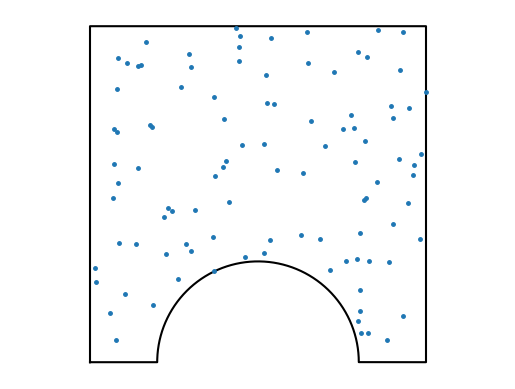

In [3]:
do_one(NKD=100, Nsample=100, plot=True, close=False);

As you increase the number of points $N$ inside the domain, the distance to the nearest point goes down like $N^{-1/2}$ and in general the scaling should be like $N^{-1/D}$ where $D$ is the number of spatial dimensions (I think). 

The required memory is linear with the number of points in the K-D tree(!)

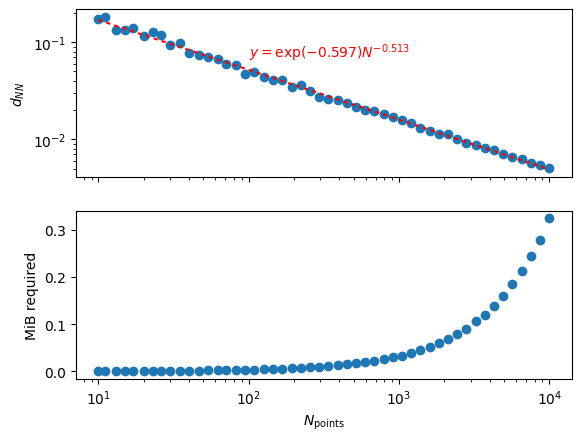

In [4]:
Ntrees = np.geomspace(10, 10**4, dtype=int)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

d2s = [do_one(NKD=NKD_, Nsample=10**3)[0] for NKD_ in Ntrees]
ax1.plot(Ntrees, d2s, 'o')

pf = np.polyfit(np.log(Ntrees), np.log(d2s), 1)
xx = np.geomspace(np.min(Ntrees), np.max(Ntrees), 1000)
ax1.plot(xx, np.exp(np.polyval(pf, np.log(xx))), dashes=[2,2], color='r')
ax1.text(100, 0.07, rf'$y=\exp({pf[1]:0.3f})N^{{{pf[0]:0.3f}}}$', color='r')
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(ylabel=r'$d_{NN}$')

MiBs = [do_one(NKD=NKD_, Nsample=10**3)[1]/1024**2 for NKD_ in Ntrees]
ax2.plot(Ntrees, MiBs, 'o')
ax2.set(xlabel=r'$N_{\rm points}$', ylabel='MiB required');

# del ptr